# **Subset geospatial data and calculate landscape metrics**

By Bridget Bittmann

Date created: March 14, 2022

Date editted: March 28, 2022

In [34]:
## IMPORT PACKAGES ##

import numpy as np #basic computation
!pip install geopandas
import geopandas as gpd #geopandas for .shp
import matplotlib.pyplot as plt #to create plots
import pandas as pd #to create dataframes and export .csv
!pip install rasterio
import rasterio as rso #import GeoTiff files
from rasterio.mask import mask #to crop data to a boundary
from rasterio.plot import show #to plot the image
from rasterio.crs import CRS
from shapely.ops import unary_union #creates boundary of shapefile
import json #imports metadata
!pip install rioxarray #to clip rasters to a .shp file
import rioxarray as rxr
from rasterio.warp import calculate_default_transform, reproject, Resampling
!pip install pylandstats
import pylandstats #to perform landscape metrics
from pylandstats import landscape
from pylandstats import SpatioTemporalAnalysis #to calculate landscape metrics through time
import glob
import os
import matplotlib.lines as lines
import matplotlib.patches as patch

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [11]:
## NAVIGATE TO YOUR DIRECTORY ##
%cd gdrive/MyDrive/spatial_colab/datasets/
%ls

/content/gdrive/MyDrive/spatial_colab/datasets
2021_clip/      climate_stats/         IrrMapper/    subset_test_shp/
Boise_CDL/      diversion_timeseries/  LBRB_shp/
CDL_reproject/  irrigation_companies/  lcmap_files/
CDL_subsets/    irrig_lbrb/            masked/


In [ ]:
## ---------------------- ##
## SUBSET GEOSPATIAL DATA ##
## ---------------------- ##

shp_file = gpd.read_file('subset_test_shp/subset.shp') #open shapefile
names = shp_file['DIV_NAME_']
files = glob.glob('lcmap_files/*.tiff') #get all the years of cdl imagery
data =[]
for i in range(len(files)):
  data.append(rso.open(files[i])) #open cdl image and append to a list
print(data)
shp = shp_file.to_crs(data[1].crs) #reproject the shp file to same projection
years = np.arange(1985, 2021) #years of LCMAP data
collection = []
for i in range(len(shp)):
  for n in range(len(years)):
    dataset = data[n]
    year_out = dataset.name[21:-15]
    extent = gpd.GeoSeries(shp['geometry'][i]) #get the geometry from shapefile
    coords = [json.loads(extent.to_json())['features'][0]['geometry']] #gets coordinates for rasterio input
    out_img, out_transform = mask(dataset=data[n], shapes=coords, crop=True, nodata=0) #crop the data to the shapefile
    out_meta = data[n].meta.copy()
    out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform})
    # Merge original file name with init_landcover to denote that it is the initial land cover data for Janus
    in_file = files[n]
    out_filename = os.path.join('lcmap_files/lcmap_masked/'+names[i]+'_'+year_out+'.tif') #create a file name to export to
    # Save clipped land cover coverage THIS WILL OVERWRITE FILES
    out_tiff = rso.open(out_filename, 'w', **out_meta)
    out_tiff.write(np.squeeze(out_img, 0), 1)
    out_tiff.close()
    collection.append(out_img)

[<open DatasetReader name='lcmap_files/LCMAP_CU_1987_V12_LCPRI.tiff' mode='r'>, <open DatasetReader name='lcmap_files/LCMAP_CU_1986_V12_LCPRI.tiff' mode='r'>, <open DatasetReader name='lcmap_files/LCMAP_CU_1989_V12_LCPRI.tiff' mode='r'>, <open DatasetReader name='lcmap_files/LCMAP_CU_1988_V12_LCPRI.tiff' mode='r'>, <open DatasetReader name='lcmap_files/LCMAP_CU_1990_V12_LCPRI.tiff' mode='r'>, <open DatasetReader name='lcmap_files/LCMAP_CU_1992_V12_LCPRI.tiff' mode='r'>, <open DatasetReader name='lcmap_files/LCMAP_CU_1991_V12_LCPRI.tiff' mode='r'>, <open DatasetReader name='lcmap_files/LCMAP_CU_1993_V12_LCPRI.tiff' mode='r'>, <open DatasetReader name='lcmap_files/LCMAP_CU_1994_V12_LCPRI.tiff' mode='r'>, <open DatasetReader name='lcmap_files/LCMAP_CU_1995_V12_LCPRI.tiff' mode='r'>, <open DatasetReader name='lcmap_files/LCMAP_CU_1996_V12_LCPRI.tiff' mode='r'>, <open DatasetReader name='lcmap_files/LCMAP_CU_1997_V12_LCPRI.tiff' mode='r'>, <open DatasetReader name='lcmap_files/LCMAP_CU_1999

In [ ]:
## ---------------------------------------- ##
## Import multiple rasters into PyLandStats ##
## ---------------------------------------- ##

temporal_group = []
for i in range(len(names)):
  files= sorted(glob.glob('lcmap_files/lcmap_masked/'+names[i]+'_*.tif')) #name for all the csv files
  sta = SpatioTemporalAnalysis(files, dates=years, nodata=0) #import all CDL rasters and mask
  temporal_group.append(sta)

In [ ]:
# ------------------------------- #
# CALCULATE THE CLASS PROPORTIONS #
# ------------------------------- #

proportions = []

for i in range(len(names)):
  df = SpatioTemporalAnalysis.compute_class_metrics_df(temporal_group[i], metrics=['proportion_of_landscape'])
  df.to_csv('lcmap_files/proportions/'+names[i]+'_prop.csv')
  proportions.append(df)

In [ ]:
# ------------------------------- #
# CALCULATE CONFIGURATION METRICS #
# ------------------------------- #

config = []

for i in range(len(names)):
  df = SpatioTemporalAnalysis.compute_landscape_metrics_df(temporal_group[i], metrics = ['contagion', 'largest_patch_index', 'shannon_diversity_index'])
  df.to_csv('lcmap_files/proportions/'+names[i]+'_configuration.csv')
  config.append(df)

In [ ]:
# ----------------------------------------------------------------- #
# Put class proportions in the same format as configuration metrics #
# ----------------------------------------------------------------- #

# Import csv files into a list of dataframes

files = glob.glob('lcmap_files/proportions/*_prop.csv')
files_config = glob.glob('lcmap_files/proportions/*_configuration.csv')
proportions = []
for i in files:
  data = pd.read_csv(i)
  proportions.append(data)
config = []
for i in files_config:
  data = pd.read_csv(i)
  config.append(data)
#Create new dataframes in same format as configuration metrics

new_df = []
for i in range(len(names)):
  df = pd.DataFrame(years, columns=['dates'])
  prop = proportions[i]
  df['class1_urban'] = prop['proportion_of_landscape'][prop['class_val'] == 1]
  df['class2_crops'] = prop['proportion_of_landscape'][prop['class_val'] == 2].values
  df['class3_grass-shrub'] = prop['proportion_of_landscape'][prop['class_val'] == 3].values
  df['class4_treecover']= prop['proportion_of_landscape'][prop['class_val'] == 4].values
  df['class5_water'] = prop['proportion_of_landscape'][prop['class_val'] == 5].values
  df['class6_wetland'] = prop['proportion_of_landscape'][prop['class_val'] == 6].values
  new_df.append(df)


In [ ]:
## -------------------- ##
## MERGE TWO DATAFRAMES ##
## -------------------- ##

merged = []

for i in range(len(names)):
  df = new_df[i]
  con = config[i]
  con = con.drop(labels='dates', axis=1)
  df_merge = pd.concat([df,con], axis=1)
  df_merge['Div_name'] = names[i]
  df_merge.to_csv('lcmap_files/final_metrics/'+names[i]+'.csv')
  merged.append(df_merge)

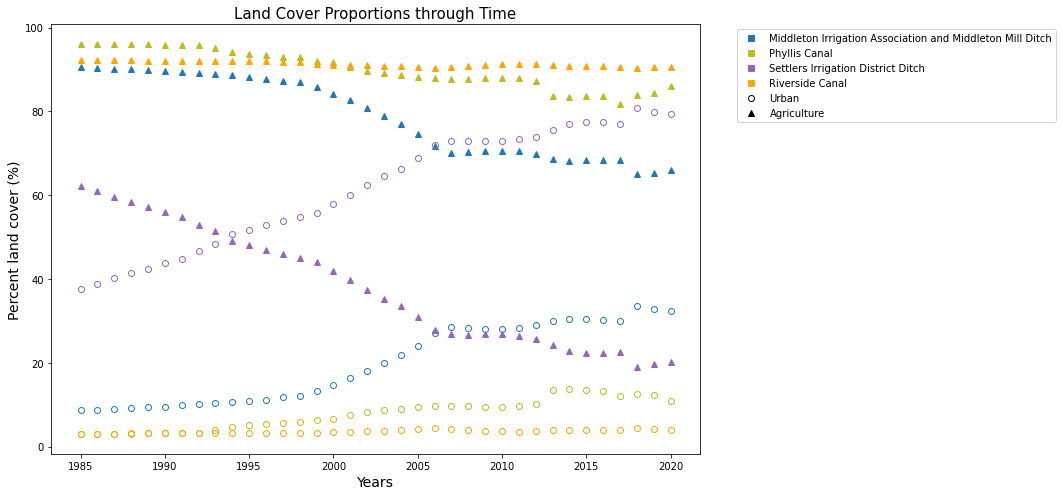

In [68]:
## ---------------------------------- ##
## PLOT TIME SERIES FOR EACH LOCATION ##
## ---------------------------------- ##

# Read in all files and append to a list
path_name = glob.glob('lcmap_files/final_metrics/*.csv')
metrics = []

for i in path_name:
  df = pd.read_csv(i)
  metrics.append(df)

#Create figure and plot proportions for ag and urban for each place

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,1,1)
ax.set_title('Land Cover Proportions through Time', size=15)
ax.set_xlabel('Years', size=14)
ax.set_ylabel('Percent land cover (%)', size=14)

cols = ['tab:blue', 'tab:olive', 'tab:purple', 'orange']
shape = ['o', '^']
names = []

for i in range(len(metrics)):
  met_df = metrics[i]
  ax.plot(met_df['dates'], met_df['class1_urban'], 'o', color=cols[i], fillstyle='none')
  ax.plot(met_df['dates'], met_df['class2_crops'], '^', color=cols[i])
  names.append(met_df['Div_name'][0])

names += ['Urban', 'Agriculture']
fill = ['none', 'full']

f = lambda m,c,fi: plt.plot([],[],marker=m, color=c, ls="none", fillstyle=fi)[0]
handle = [f('s', cols[i], 'full') for i in range(len(cols))]
handle += [f(shape[i], "k", fill[i]) for i in range(len(shape))]

plt.legend(handles=handle, labels=names, bbox_to_anchor=(1.05,1.0), loc='upper left')
plt.tight_layout()
plt.savefig('lcmap_files/figures/proportions.jpg')